In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch

import re
import nltk
from nltk.corpus import stopwords

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from collections import defaultdict, Counter

from gensim.models import KeyedVectors
from transformers import BertModel, BertTokenizer

import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
w2v_file = ''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_name = os.path.join(dirname, filename)
        if file_name.endswith('.bin') or ('.gz'):
            w2v_file = file_name
        else:
            print(f'Found unexpected file: {file_name}')
                
print(f'Google news word to vec file: {w2v_file}')
print(f'{w2v_file} can map words onto vectors with 300 dimensions')

# Checks if a CUDA enabled GPU is available and prints out its information
if torch.cuda.is_available():
    print("CUDA is available!")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        
    device = torch.device("cuda:0")

else:
    print("CUDA is not available.")
    device = torch.device("cpu")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-08-22 21:50:29.599857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 21:50:29.599977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 21:50:29.723506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Google news word to vec file: /kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin can map words onto vectors with 300 dimensions
CUDA is available!
GPU 0: Tesla P100-PCIE-16GB


# Global Variables

In [2]:
# global variables

w2v = KeyedVectors.load_word2vec_format(w2v_file, binary=True)
vector_dim = 300

corpus = """In the dense rainforest, exotic flowers bloomed amidst lush 
    vegetation, while the nearby desert remained arid and barren. The stark 
    contrast between these ecosystems fascinated ecologists and botanists alike. 
    Meanwhile, in the bustling city, a team of brilliant scientists collaborated 
    on groundbreaking artificial intelligence research, developing algorithms for 
    natural language processing and computer vision. Their work drew attention 
    from tech giants and startups, sparking debates about ethics and privacy. 
    As the sun set, casting long shadows across the urban landscape, a group of 
    friends gathered at a local café to discuss literature, philosophy, and the 
    latest advancements in quantum computing. The aroma of freshly brewed coffee
    mingled with the scent of old books, creating an atmosphere conducive to 
    intellectual discourse and creative thinking. On the outskirts of the city, 
    by the riverbank, a fisherman patiently waited with his rod, while in the 
    financial district, bankers discussed the latest policies affecting the 
    central bank. The word "bank" echoed through different conversations, each 
    with its own distinct meaning."""

# Tokenizer

In [3]:
def tokenizer(text):
    """Tokenize and remove the stop words from the text"""
    # Download the stopwords & get list of stop words for English
    # nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    
    # tokenize text
    tokens = re.findall(r'\w+', text.lower()) # tokens = nltk.word_tokenize(text.lower())
    
    # Remove stop words and count occurrences
    removed_stop_words = Counter(word for word in tokens if word in stop_words)
    filtered_text = [word for word in tokens if word not in stop_words]
        
    return tokens, filtered_text

# Embeddings:

## Random

In [4]:
def get_random_embeddings(words):
    """Generates random embeddings for the given words."""
    random_vectors = []
    for token in words:
        random_vectors.append(np.random.rand(vector_dim))
    return np.array(random_vectors), words

## W2V/Semantic

In [5]:
def get_w2v_embeddings(words, w2v_model):
    """Retrieves Word2Vec embeddings for the given words."""
    w2v_vectors = []
    for token in words:
        if token in w2v_model.key_to_index:
            w2v_vectors.append(w2v_model[token])
        else:
            w2v_vectors.append(np.zeros(vector_dim))
    return np.array(w2v_vectors), words

## BERT/Contextual 

In [6]:
def get_attention_embeddings(words, max_length=512):
    """
    Generates attention embeddings using a pre-trained BERT model.
    
    Slighly modified to account for BERT's 512 token limit
    """
    model = BertModel.from_pretrained('bert-base-uncased')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    all_embeddings = []
    
    # Split input into chunks of max_length tokens
    for i in range(0, len(words), max_length):
        chunk = words[i:i + max_length]
        input_ids = tokenizer.encode(chunk, add_special_tokens=False, return_tensors='pt')
        
        with torch.no_grad():
            outputs = model(input_ids)
            attention_embeddings = outputs.last_hidden_state.squeeze(0).numpy()
            all_embeddings.append(attention_embeddings)
    
    # Concatenate all embeddings
    return np.concatenate(all_embeddings, axis=0)

# Graphs:

## 2D / 3D t-SNE

In [7]:
def visualize_embeddings_tsne(embeddings, words):
    
    warnings.filterwarnings("ignore", category=FutureWarning, message=".*get_group.*")
    
    tsne_2d = TSNE(perplexity=30, n_components=2, random_state=42)
    tsne_3d = TSNE(perplexity=30, n_components=3, random_state=42)
    
    proj_2d = tsne_2d.fit_transform(embeddings)
    proj_3d = tsne_3d.fit_transform(embeddings)
    
    # Limit hover_name entries to match projected points
    limited_words = words[: len(proj_2d)]  # Truncate words to match projection size
    
    fig_2d = px.scatter(
        proj_2d, x=0, y=1,
        text=limited_words,  # Display text labels on the points
        labels={'color': 'words'}
    )
    fig_3d = px.scatter_3d(
        proj_3d, x=0, y=1, z=2,
        text=limited_words,  # Display text labels on the points
        labels={'color': 'words'}
    )
    fig_3d.update_traces(marker_size=5)
    
    fig_2d.show()
    fig_3d.show()

## 2D / 3D UMAP

In [8]:
def visualize_embeddings_umap(embeddings, words):
    # Suppress UserWarning from UMAP
    warnings.filterwarnings("ignore", category=UserWarning, message=".*n_jobs value 1 overridden.*")

    umap_2d = UMAP(n_neighbors=5, min_dist=0.05, n_components=2, metric='cosine', random_state=42)
    umap_3d = UMAP(n_neighbors=5, min_dist=0.05, n_components=3, metric='cosine', random_state=42)

    proj_2d = umap_2d.fit_transform(embeddings)
    proj_3d = umap_3d.fit_transform(embeddings)

    # Limit hover_name entries to match projected points
    limited_words = words[: len(proj_2d)]  # Truncate words to match projection size
    
    fig_2d = px.scatter(
        proj_2d, x=0, y=1,
        text=limited_words,  # Display text labels on the points
        labels={'color': 'words'}
    )
    fig_3d = px.scatter_3d(
        proj_3d, x=0, y=1, z=2,
        text=limited_words,  # Display text labels on the points
        labels={'color': 'words'}
    )
    fig_3d.update_traces(marker_size=5)
    
    fig_2d.show()
    fig_3d.show()

## Force-Directed Graph

In [9]:
def visualize_embeddings_force_directed(embeddings, words):
    # Ensure embeddings and words list are the same length
    assert embeddings.shape[0] == len(words), "Embeddings and words list must be the same length"

    # Compute pairwise cosine similarities
    distances = pdist(embeddings, metric='cosine')
    similarity_matrix = 1 - squareform(distances)

    # Create a graph with NetworkX
    G = nx.Graph()

    for i, word in enumerate(words):
        G.add_node(i, label=word)

    for i in range(len(words)):
        for j in range(i + 1, len(words)):
            similarity = similarity_matrix[i, j]
            if similarity > 0.5:  # Add edge if similarity is above a threshold
                G.add_edge(i, j, weight=similarity)

    # Get node positions using a force-directed layout
    pos = nx.spring_layout(G, weight='weight', seed=42)

    # Prepare data for Plotly
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=[G.nodes[node]['label'] for node in G.nodes()],
        hoverinfo='text',
        marker=dict(
            size=10,  # Size of the markers
            color=node_y,  # Color based on the y-position
            colorscale='YlGnBu',  # Color scale
            showscale=True,  # Show color scale
            colorbar=dict(
                thickness=15,  # Thickness of the color bar
                title='Node Position',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)  # Outline width of the markers
        )
    )

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=0),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)))

    fig.show()

## Dendrogram

In [10]:
def plot_dendrogram(embeddings, words, method='ward'):
    """
    Plots a dendrogram for the given embeddings.
    
    Parameters:
    - embeddings (numpy.ndarray): The embeddings array of shape (num_tokens, embedding_dim).
    - words (list): The list of all tokens corresponding to the embeddings.
    - method (str): The linkage method to use for hierarchical clustering. Default is 'ward'.
    """
    # Compute the cosine distance matrix
    distance_matrix = cosine_distances(embeddings)
    
    # Convert the full distance matrix to a condensed distance matrix
    condensed_distance_matrix = sch.distance.squareform(distance_matrix, checks=False)
    
    # Perform hierarchical/agglomerative clustering
    linkage_matrix = sch.linkage(condensed_distance_matrix, method=method)
    
    # Plot the dendrogram
    plt.figure(figsize=(10, 22))  # Adjust the figure size for better visibility
    sch.dendrogram(linkage_matrix, labels=words, leaf_rotation=0, leaf_font_size=10, orientation='right')
    plt.title(f"Dendrogram ({method.capitalize()} Linkage)")
    plt.xlabel('Distance')  # Distance is now on the horizontal axis
    plt.ylabel('Tokens')  # Tokens are now on the vertical axis
    plt.show()

# Quantitative Evals:

## Silhouette Coefficient
## Davies-Bouldin Index
## Calinski-Harabasz Index

In [11]:
def evaluate_embeddings(embeddings, n_clusters=5):
    """Evaluates the embeddings using clustering metrics."""
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(embeddings)
    
    # Compute Silhouette Coefficient
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    
    # Compute Davies-Bouldin Index
    davies_bouldin_avg = davies_bouldin_score(embeddings, cluster_labels)
    
    # Compute Calinski-Harabasz Index
    calinski_harabasz_avg = calinski_harabasz_score(embeddings, cluster_labels)
    
    return silhouette_avg, davies_bouldin_avg, calinski_harabasz_avg

## Token Similarity by Cosine Distance

In [12]:
def get_closest_tokens(token, embeddings, token_list, top_n=5):
    """
    Given a token, returns the top_n closest tokens based on cosine similarity.
    
    Parameters:
    - token (str): The token for which to find the closest tokens.
    - embeddings (numpy.ndarray): The embeddings array of shape (num_tokens, embedding_dim).
    - token_list (list): The list of all tokens corresponding to the embeddings.
    - top_n (int): The number of closest tokens to return. Default is 5.
    
    Returns:
    - List of tuples where each tuple is (token, similarity_score).
    """
    # Check if the token is in the token list
    if token not in token_list:
        raise ValueError(f"Token '{token}' not found in the token list.")
    
    # Get the index of the token
    token_index = token_list.index(token)
    
    # Get the embedding of the token
    token_embedding = embeddings[token_index].reshape(1, -1)
    
    # Calculate cosine similarities between the token and all other tokens
    similarities = cosine_similarity(token_embedding, embeddings).flatten()
    
    # Get the indices of the top_n most similar tokens (excluding the token itself)
    most_similar_indices = similarities.argsort()[-top_n-1:-1][::-1]
    
    # Return the tokens and their similarity scores
    closest_tokens = [(token_list[idx], similarities[idx]) for idx in most_similar_indices]
    
    return closest_tokens

# Main

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

t-SNE - Random Embeddings


t-SNE - W2V Embeddings


t-SNE - BERT Embeddings


UMAP - Random Embeddings


UMAP - W2V Embeddings


UMAP - BERT Embeddings


Force-Directed for Random Embeddings


Force-Directed for W2V Embeddings


Force-Directed for BERT Embeddings


Dendrogram for Random Embeddings


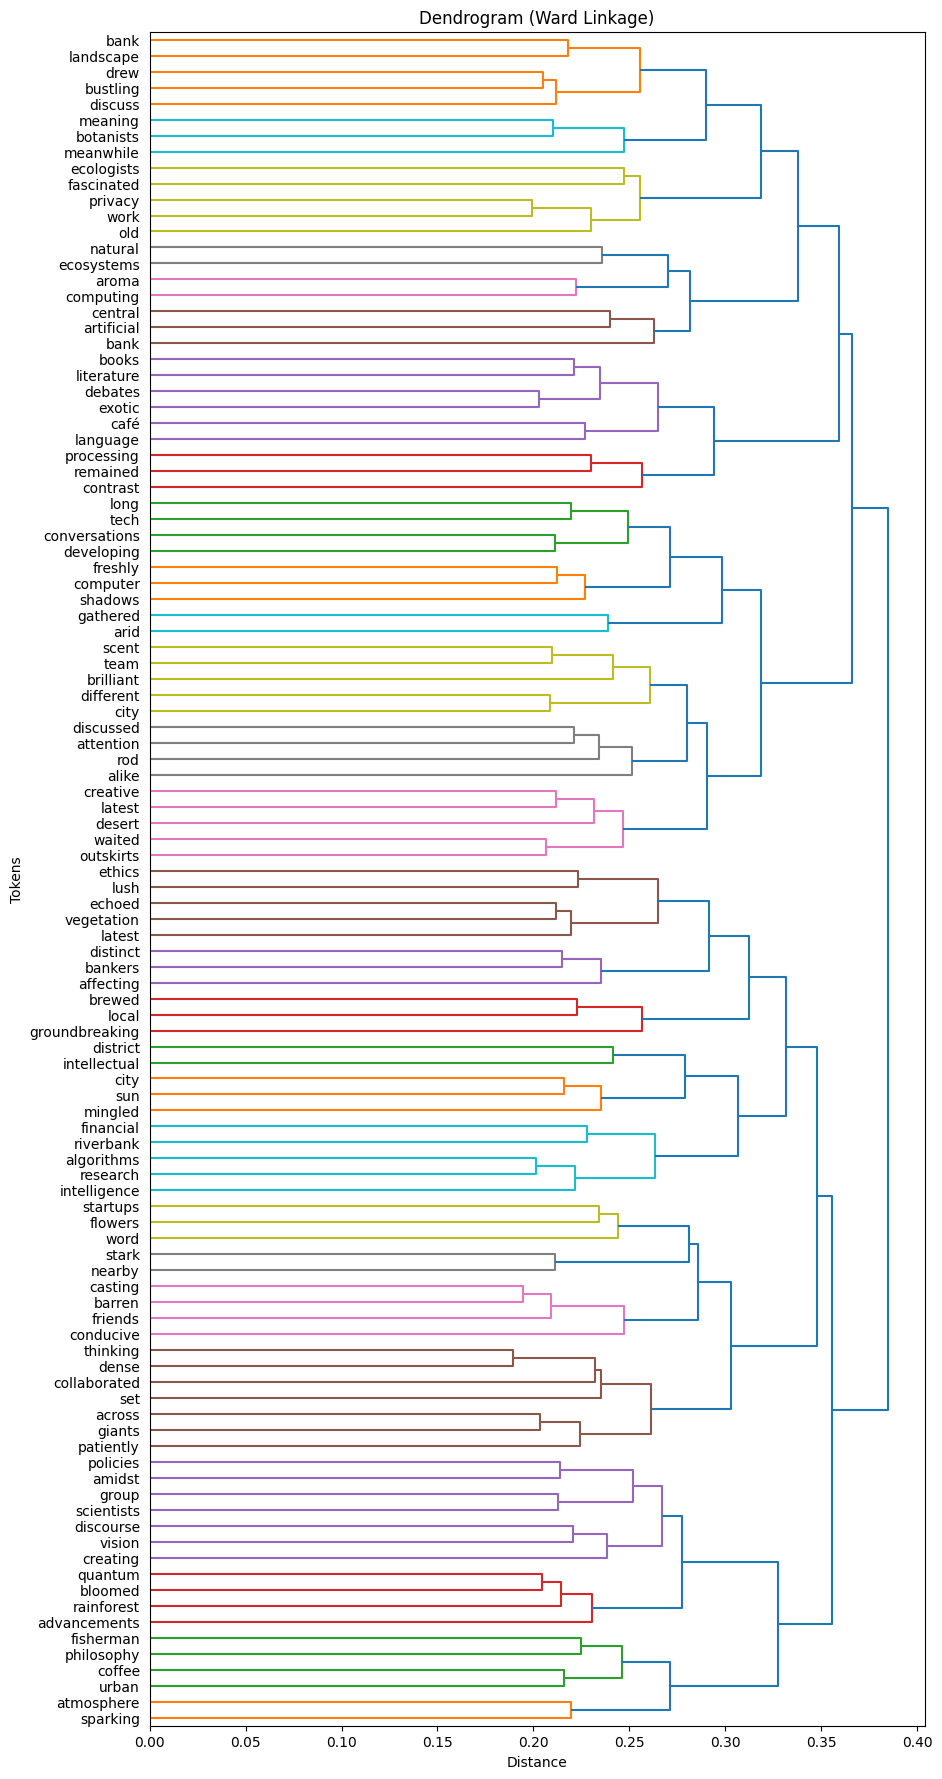

Dendrogram for Word2Vec Embeddings


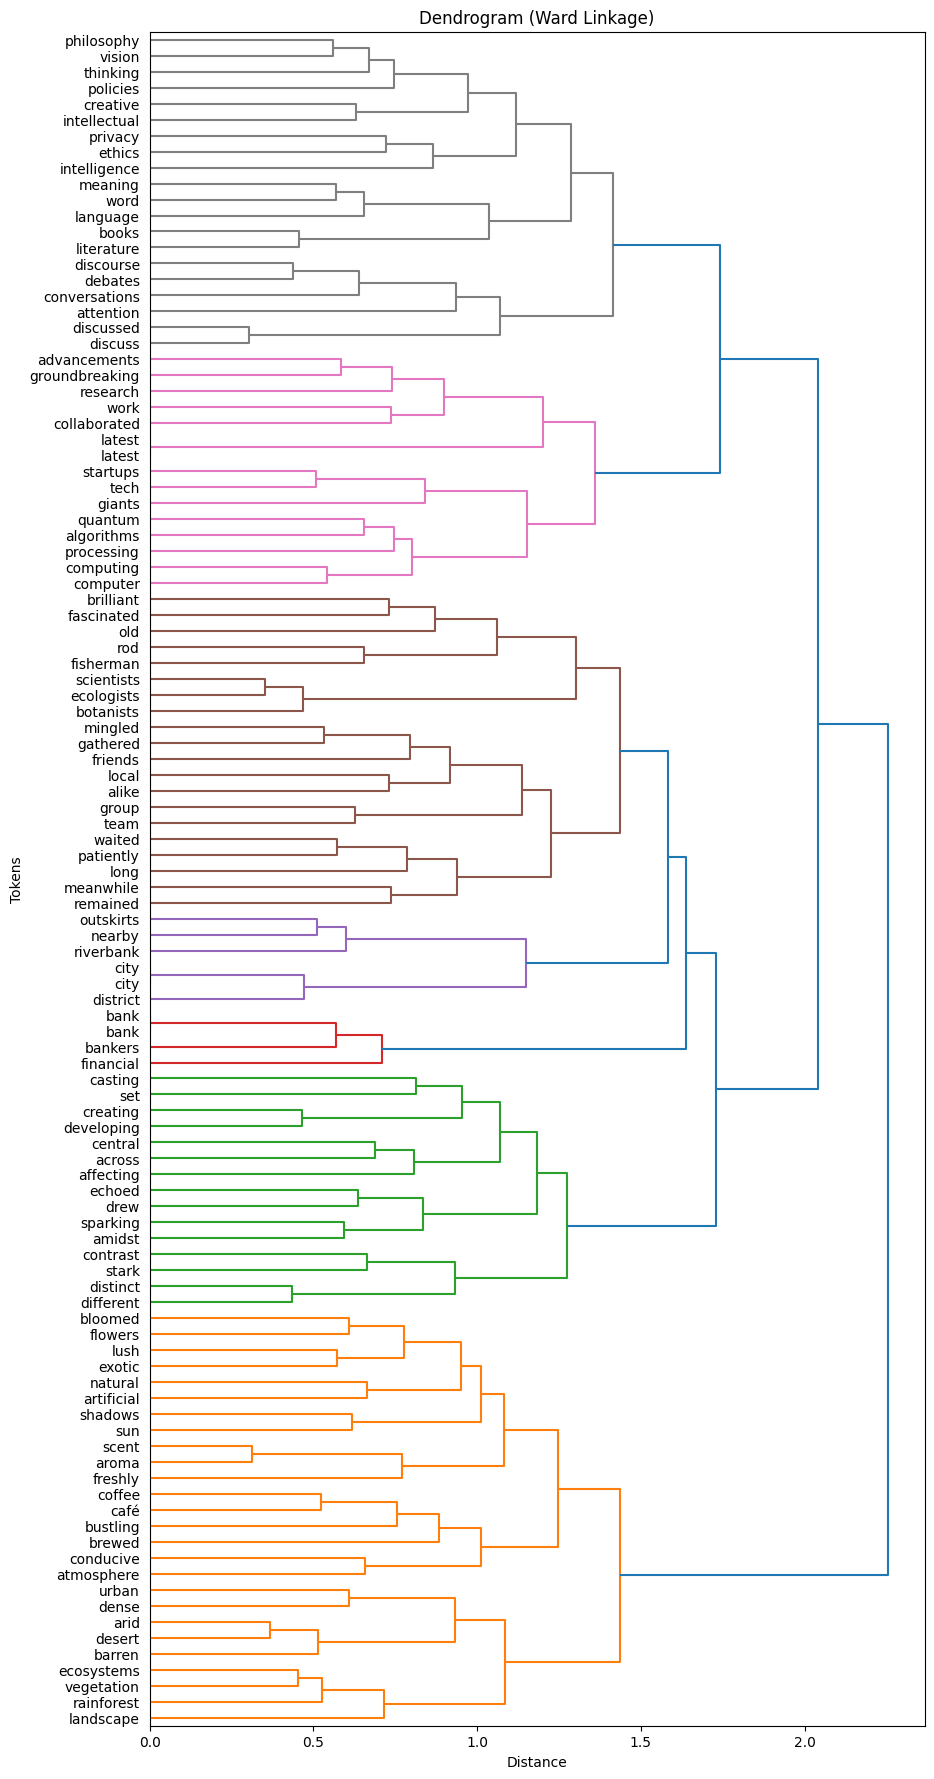

Dendrogram for BERT-based Embeddings


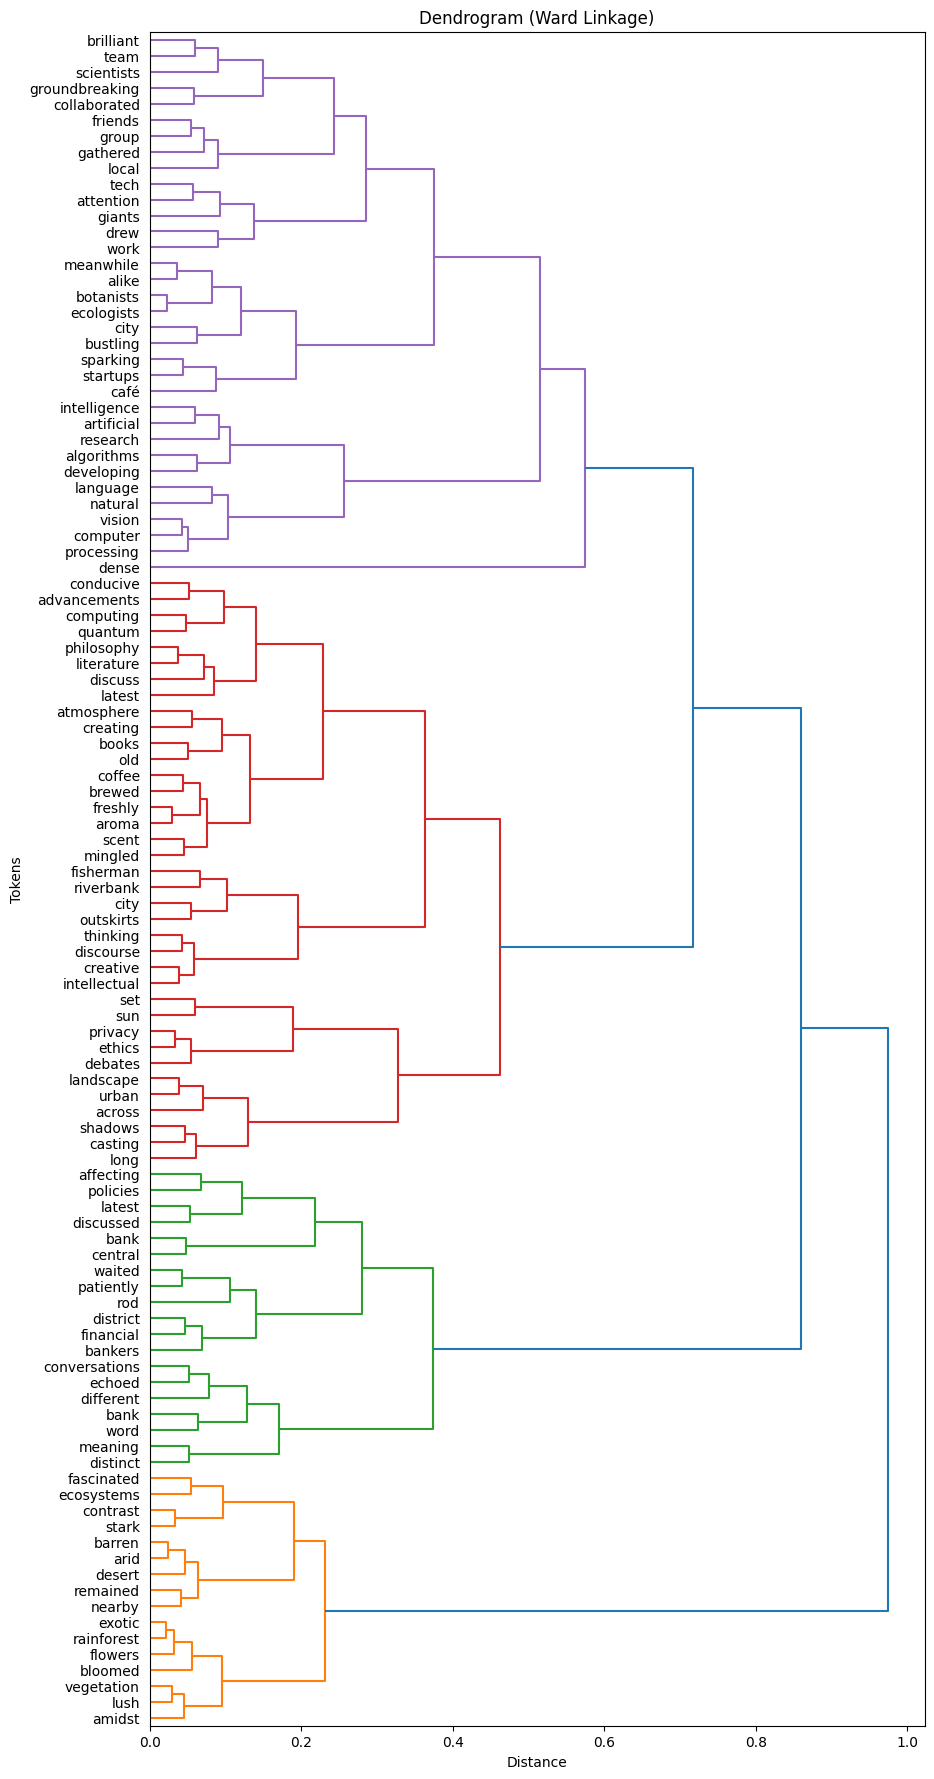

Random Embeddings - Silhouette Coefficient: -0.0013627576042393873 Davies-Bouldin Index: 5.366426423180007 Calinski-Harabasz Index: 1.3955724756307584
Word2Vec Embeddings - Silhouette Coefficient: 0.016567897 Davies-Bouldin Index: 3.588893147497496 Calinski-Harabasz Index: 3.089192711643906
BERT Embeddings - Silhouette Coefficient: 0.18785885 Davies-Bouldin Index: 1.824176346408772 Calinski-Harabasz Index: 15.359477776694227

Closest tokens to artificial using Random embeddings:
Token: aroma, Similarity: 0.7758
Token: brewed, Similarity: 0.7734
Token: vegetation, Similarity: 0.7728
Token: casting, Similarity: 0.7722
Token: long, Similarity: 0.7711

Closest tokens to artificial using Word2Vec embeddings:
Token: natural, Similarity: 0.3374
Token: conducive, Similarity: 0.2697
Token: exotic, Similarity: 0.2690
Token: lush, Similarity: 0.2562
Token: flowers, Similarity: 0.2509

Closest tokens to artificial using BERT-based embeddings:
Token: intelligence, Similarity: 0.9399
Token: developi

In [13]:
def main():
    text = corpus
    all_tokens, filtered_tokens = tokenizer(text)

    # Generate embeddings
    random_embeddings, _ = get_random_embeddings(filtered_tokens)
    w2v_embeddings, _ = get_w2v_embeddings(filtered_tokens, w2v)
    attention_embeddings = get_attention_embeddings(filtered_tokens)
    
    # 2d/3d t-sne visualizations
    print("t-SNE - Random Embeddings")
    visualize_embeddings_tsne(random_embeddings, filtered_tokens)
    print("t-SNE - W2V Embeddings")
    visualize_embeddings_tsne(w2v_embeddings, filtered_tokens)
    print("t-SNE - BERT Embeddings")
    visualize_embeddings_tsne(attention_embeddings, filtered_tokens)
    
    # 2d/3d umap visualizations
    print("UMAP - Random Embeddings")
    visualize_embeddings_umap(random_embeddings, filtered_tokens)
    print("UMAP - W2V Embeddings")
    visualize_embeddings_umap(w2v_embeddings, filtered_tokens)
    print("UMAP - BERT Embeddings")
    visualize_embeddings_umap(attention_embeddings, filtered_tokens)
    
    # force-directed graph Visualization
    print("Force-Directed for Random Embeddings")
    visualize_embeddings_force_directed(random_embeddings, filtered_tokens)
    print("Force-Directed for W2V Embeddings")
    visualize_embeddings_force_directed(w2v_embeddings, filtered_tokens)
    print("Force-Directed for BERT Embeddings")
    visualize_embeddings_force_directed(attention_embeddings, filtered_tokens)
    
    # Plot dendrograms for each type of embedding
    print("Dendrogram for Random Embeddings")
    plot_dendrogram(random_embeddings, filtered_tokens, method='ward')
    print("Dendrogram for Word2Vec Embeddings")
    plot_dendrogram(w2v_embeddings, filtered_tokens, method='ward')
    print("Dendrogram for BERT-based Embeddings")
    plot_dendrogram(attention_embeddings, filtered_tokens, method='ward')
    
    # Evaluate embeddings
    random_silhouette, random_db, random_ch = evaluate_embeddings(random_embeddings)
    w2v_silhouette, w2v_db, w2v_ch = evaluate_embeddings(w2v_embeddings)
    bert_silhouette, bert_db, bert_ch = evaluate_embeddings(attention_embeddings)

    # Print the results
    print("Random Embeddings - Silhouette Coefficient:", random_silhouette,
          "Davies-Bouldin Index:", random_db, "Calinski-Harabasz Index:", random_ch)
    
    print("Word2Vec Embeddings - Silhouette Coefficient:", w2v_silhouette,
          "Davies-Bouldin Index:", w2v_db, "Calinski-Harabasz Index:", w2v_ch)
    
    print("BERT Embeddings - Silhouette Coefficient:", bert_silhouette,
          "Davies-Bouldin Index:", bert_db, "Calinski-Harabasz Index:", bert_ch)
    
    # Find closest tokens
    closest_token = 'artificial'
    
    closest_to_token_random = get_closest_tokens(closest_token, random_embeddings, filtered_tokens, top_n=5)
    closest_to_token_w2v = get_closest_tokens(closest_token, w2v_embeddings, filtered_tokens, top_n=5)
    closest_to_token_bert = get_closest_tokens(closest_token, attention_embeddings, filtered_tokens, top_n=5)
    
    # Print the results
    print(f"\nClosest tokens to {closest_token} using Random embeddings:")
    for token, similarity in closest_to_token_random:
        print(f"Token: {token}, Similarity: {similarity:.4f}")
    
    print(f"\nClosest tokens to {closest_token} using Word2Vec embeddings:")
    for token, similarity in closest_to_token_w2v:
        print(f"Token: {token}, Similarity: {similarity:.4f}")
    
    print(f"\nClosest tokens to {closest_token} using BERT-based embeddings:")
    for token, similarity in closest_to_token_bert:
        print(f"Token: {token}, Similarity: {similarity:.4f}")

if __name__ == "__main__":
    main()